In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


/Users/mac/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Titanic Dataset

In [2]:
train=pd.read_csv('train.csv')
print train.shape
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparing the Data

In [3]:
train.apply(lambda x: x.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# lets format sex : (Male==1) & (Female==2)
train['Sex']=(train['Sex']=='male')*1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


- *The column 'Cabin' contains 687(for a total of 891) NAN therefore we are going to drop it for the linear models and keep it for nonlinear model such as random trees*.
- notice that Age column got 177 missing. We have two option: replace missing values with mean or generate from normale distribution (age follow normal distribution!) !

In [6]:
#lets delete cabin
del train['Cabin']

In [7]:
# lets the find out the reason behind age missing data 
maskMiss=train.Age.isnull()
print np.mean(train.Sex[maskMiss])
print np.mean(train.Embarked[maskMiss]=='Q')
print np.mean(train.Embarked[maskMiss]=='C')
print np.mean(train.Embarked[maskMiss]=='S')


0.700564971751
0.276836158192
0.214689265537
0.508474576271


In [8]:
# lets fill the missing age data with 0.7meanMale+0.3 meanFemale

meanMale=np.mean(train.Age[train.Sex==1])
meanFemale=np.mean(train.Age[train.Sex==0])
print 'Male mean', meanMale
print 'Female mean',meanFemale
mean=0.7*meanMale+0.3*meanFemale
print 'mean',mean

#lets replace age miss
train.Age.fillna(mean,inplace=True)




Male mean 30.7266445916
Female mean 27.9157088123
mean 29.8833638578


In [9]:
# lets impute the 2 embarked miss values
train=train.dropna(subset=['Embarked'], how='all')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S


# EDA

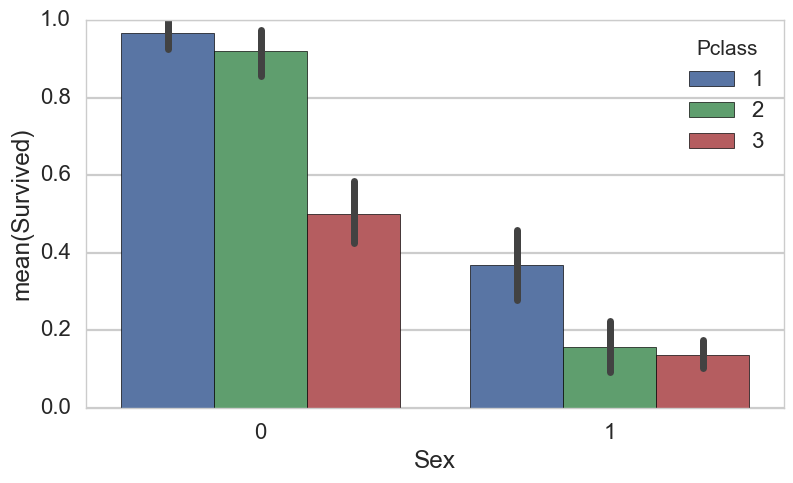

In [10]:
# Females survived more than men
sns.set_context(rc={"figure.figsize": (9, 5)})
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=train);

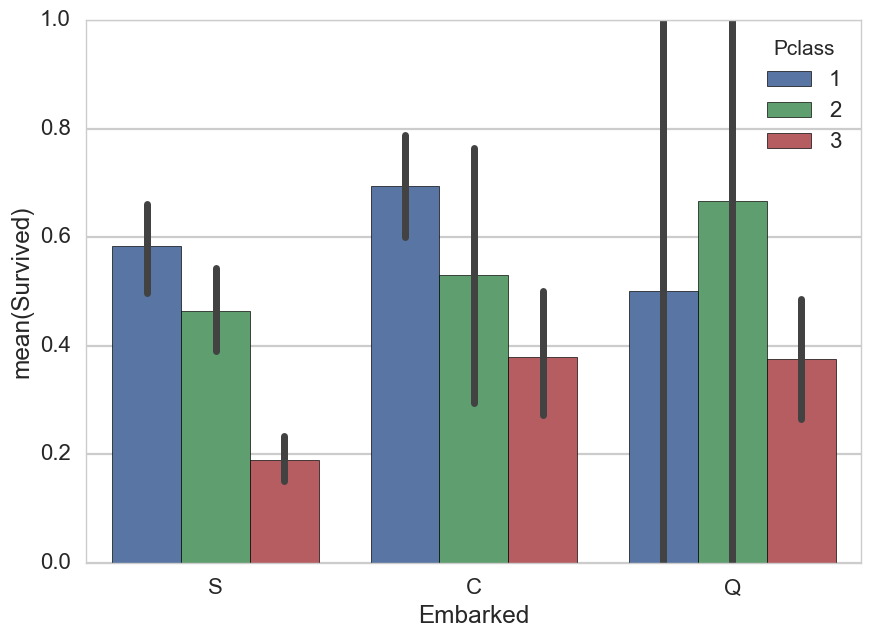

In [11]:
# Females survived more than men
sns.set_context(rc={"figure.figsize": (10, 7)})
sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=train);

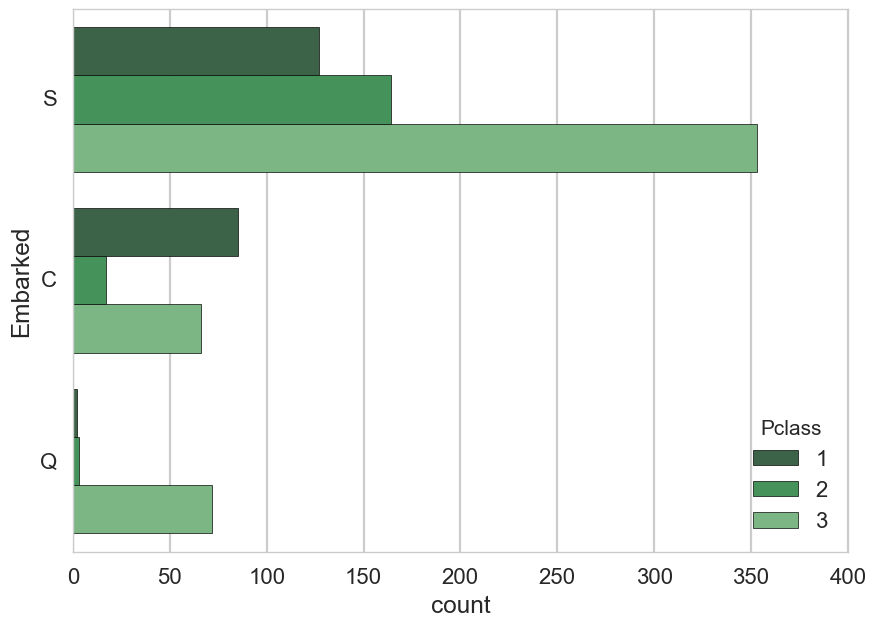

In [12]:
sns.countplot(y="Embarked", hue="Pclass", data=train, palette="Greens_d");

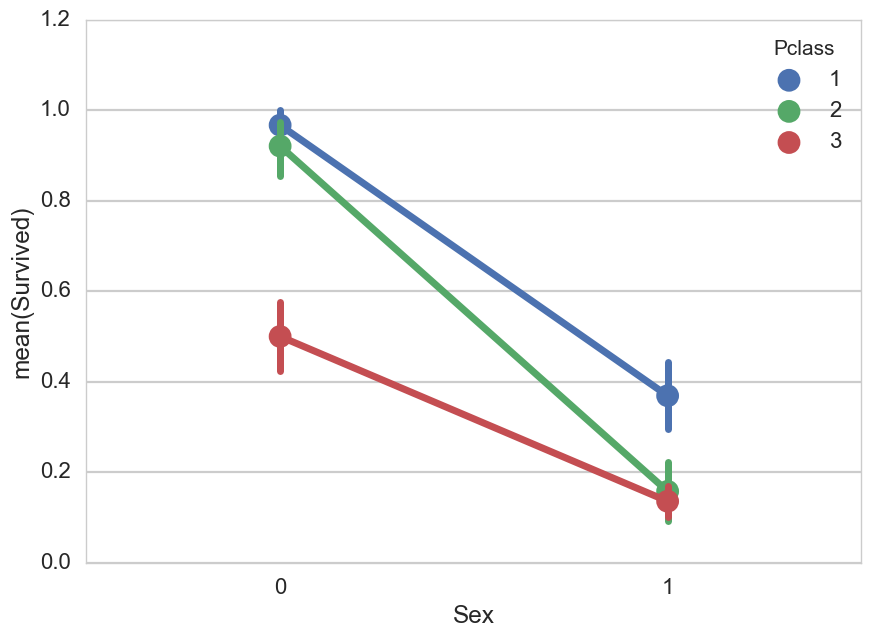

In [13]:
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=train);

# Apply Machine Learning for prediction

In [14]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1,train_size=0.7):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

## Linear/Non Linear models

Linear classifiers:
- Linear Regression
- Logistic Regression
- Linear Discriminant Analysis
- perceptron
- Support Vector Machines



Non Linear classifiers:
- Classification And Regression Trees
- Naive Bayes
- K-Nearest Neighbors
- Bagging and Random Forest
- Boosting and AdaBoost


### 1.Logistic regression

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S


In [17]:
linearTrain=train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Survived']]
linearTrain=pd.get_dummies(linearTrain)

In [18]:
# a dataframe suitable for linear models such as logistic regression
print linearTrain.shape
linearTrain.head()

(889, 10)


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1,1.0,0.0,0.0
2,3,0,26.0,0,0,7.9250,1,0.0,0.0,1.0
3,1,0,35.0,1,0,53.1000,1,0.0,0.0,1.0
4,3,1,35.0,0,0,8.0500,0,0.0,0.0,1.0


In [19]:
#Features names used for the linear models are:
featurenames=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S']

In [20]:
clf_log, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(penalty='l1'),
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, linearTrain,
                                                           ['Pclass','Sex','Age',
                                                            'SibSp','Parch'
                                                            ,'Fare','Embarked_C','Embarked_Q','Embarked_S']
                                                           , 'Survived',1)

BEST {'C': 10} 0.787781350482 [mean: 0.65595, std: 0.02766, params: {'C': 0.01}, mean: 0.77653, std: 0.03137, params: {'C': 0.1}, mean: 0.78457, std: 0.02701, params: {'C': 1}, mean: 0.78778, std: 0.03199, params: {'C': 10}, mean: 0.78617, std: 0.03194, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.80
Accuracy on test data:     0.82
[[155  20]
 [ 27  65]]
########################################################


*Feature selection can be done in two option*:
- Reduce the number of features(manually selection features or by using algorithm PCA auto-encoder neural networks)
- Regularization (penalizing the useless features L2-norm or sparsifying and eliminating useless features look example above  {"C": [0.01, 0.1, 1, 10, 100]} 

In [21]:
linearTrain.corr()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S
Pclass,1.000000,0.127741,-0.326971,0.081656,0.016824,-0.548193,-0.335549,-0.245733,0.220558,0.076466
Sex,0.127741,1.000000,0.089737,-0.116348,-0.247508,-0.179958,-0.541585,-0.084520,-0.075217,0.121405
Age,-0.326971,0.089737,1.000000,-0.231765,-0.178935,0.088036,-0.075187,0.034038,-0.010909,-0.022957
SibSp,0.081656,-0.116348,-0.231765,1.000000,0.414542,0.160887,-0.034040,-0.060074,-0.026692,0.069438
Parch,0.016824,-0.247508,-0.178935,0.414542,1.000000,0.217532,0.083151,-0.011588,-0.081585,0.061512
Fare,-0.548193,-0.179958,0.088036,0.160887,0.217532,1.000000,0.255290,0.270731,-0.116684,-0.163758
Survived,-0.335549,-0.541585,-0.075187,-0.034040,0.083151,0.255290,1.000000,0.169966,0.004536,-0.151777
Embarked_C,-0.245733,-0.084520,0.034038,-0.060074,-0.011588,0.270731,0.169966,1.000000,-0.148646,-0.782613
Embarked_Q,0.220558,-0.075217,-0.010909,-0.026692,-0.081585,-0.116684,0.004536,-0.148646,1.000000,-0.499261
Embarked_S,0.076466,0.121405,-0.022957,0.069438,0.061512,-0.163758,-0.151777,-0.782613,-0.499261,1.000000


Selecting features that are highly correlated with our target:
-  Sex = -0.541585
-  Pclass= -0.335549
-  Fare=  0.255290
.....

* common mistakes:
- Selecting features or creating new representative ones using PCA
- Cross-validation set is transformed(via PCA) with the training dataset !

In [22]:
# Applying PCA 
from sklearn import preprocessing
from sklearn.decomposition import PCA
n_component=2
StandardScaler = preprocessing.StandardScaler()
linearTrainScaledPC = StandardScaler.fit_transform(linearTrain)
pca = PCA(n_components=n_component)
X = pca.fit_transform(linearTrainScaledPC)

In [23]:
print pca.explained_variance_ratio_
print 'Total explained variance=', pca.explained_variance_ratio_.sum()

[ 0.23989382  0.18183042]
Total explained variance= 0.421724244748


In [24]:
dic={"pc%i" % (i+1):X[:,i] for i in range(n_component)}
dic.keys()

['pc2', 'pc1']

In [25]:
#lets create a dataframe for the two pricipal components

PCAdf=pd.DataFrame(dic)
PCAdf['Survived']=linearTrain.Survived.values
PCAdf['Pclass']=linearTrain.Pclass.values
PCAdf.head()

,pc1,pc2,Survived,Pclass
0,-1.663394,0.187890,0,3
1,3.502495,-0.674579,1,1
2,-0.136922,0.593016,1,3
3,1.326088,0.944404,1,1
4,-1.605255,-0.531220,0,3


In [26]:
# lets try fitting again with these pca's
clf_log, Xtrain, ytrain, Xtest, ytest  = do_classify(LogisticRegression(penalty='l2'),
                                                           {"C": [0.01, 0.1, 1, 10,100]}, PCAdf,
                                                           dic.keys()
                                                           , 'Survived',1)

BEST {'C': 0.01} 0.826366559486 [mean: 0.82637, std: 0.02942, params: {'C': 0.01}, mean: 0.81833, std: 0.02457, params: {'C': 0.1}, mean: 0.81833, std: 0.02457, params: {'C': 1}, mean: 0.81833, std: 0.02457, params: {'C': 10}, mean: 0.81833, std: 0.02457, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.78
[[139  23]
 [ 35  70]]
########################################################


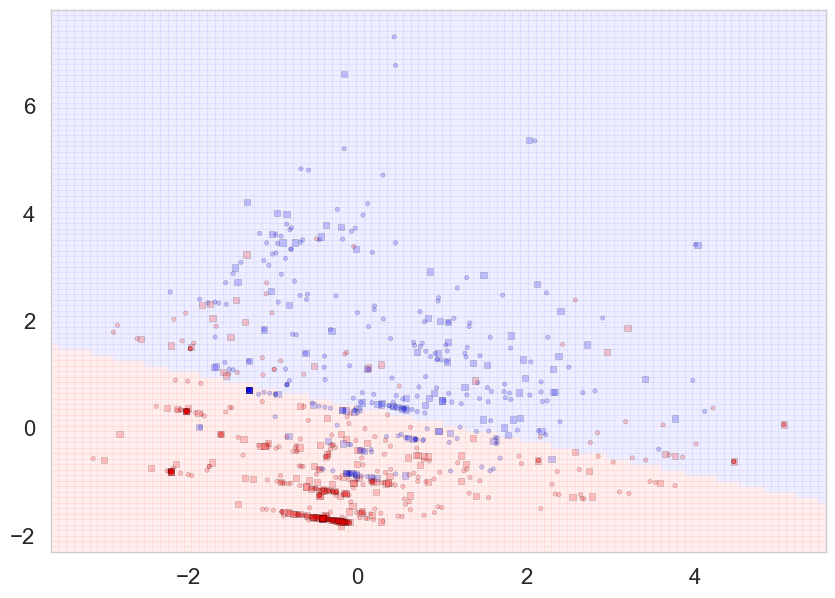

In [27]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf_log, alpha=0.2);

### Standardization AKA Z-score normalization
$$z = \frac{x - \mu}{\sigma}$$

Standardizing the features so that they are centered around 0 with a standard deviation of 1. Some examples of algorithms where feature scaling matters are:
- k-nearest neighbors with an Euclidean distance measure if want all features to contribute equally
- k-means (see k-nearest neighbors)
- logistic regression, SVMs, perceptrons, neural networks etc. if you are using gradient descent/ascent-based optimization, otherwise some weights will update much faster than others
- linear discriminant analysis, principal component analysis, kernel principal component analysis since you want to find directions of maximizing the variance (under the constraints that those directions/eigenvectors/principal components are orthogonal); you want to have features on the same scale since you’d emphasize variables on “larger measurement scales” more. There are many more cases than I can possibly list here … I always recommend you to think about the algorithm and what it’s doing, and then it typically becomes obvious whether we want to scale your features or not.

### Min-Max scaling AKA Normalization
$$X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}}$$
- In this approach, the data is scaled to a fixed range - usually 0 to 1.
- The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers.

http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

### 3.Support Vector Machines

Need to specify:
- Choice of parameter C
- Choice of kernel


kernels:
- Linear kernel/logistic regression for n(number of features) large and small m(training examples) (n=10000 m=10-1000)
- Gaussian kernel n small and m intermediate (non linear classification) (n=1-1000 m=10-10000)
- Linear kernel/logistic regression (n=1-1000 m=50000+) create more features

In [28]:
# in our case m=800 and n=10 we use Gaussian kernel
linearTrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.0,1,0,7.2500,0,0.0,0.0,1.0
1,1,0,38.0,1,0,71.2833,1,1.0,0.0,0.0
2,3,0,26.0,0,0,7.9250,1,0.0,0.0,1.0
3,1,0,35.0,1,0,53.1000,1,0.0,0.0,1.0
4,3,1,35.0,0,0,8.0500,0,0.0,0.0,1.0


In [29]:
# first lets standarize the data
LineatrainScaled = preprocessing.StandardScaler().fit_transform(linearTrain.drop(['Survived'],axis=1))
LineatrainScaled=pd.DataFrame(LineatrainScaled,columns=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_C','Embarked_Q','Embarked_S'])
LineatrainScaled['Survived']=linearTrain.Survived.values

In [30]:
LineatrainScaled.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0.825209,0.735342,-0.593310,0.431350,-0.474326,-0.500240,-0.482711,-0.307941,0.616794,0
1,-1.572211,-1.359911,0.641124,0.431350,-0.474326,0.788947,2.071634,-0.307941,-1.621287,1
2,0.825209,-1.359911,-0.284701,-0.475199,-0.474326,-0.486650,-0.482711,-0.307941,0.616794,1
3,-1.572211,-1.359911,0.409668,0.431350,-0.474326,0.422861,-0.482711,-0.307941,0.616794,1
4,0.825209,0.735342,0.409668,-0.475199,-0.474326,-0.484133,-0.482711,-0.307941,0.616794,0


In [36]:
from sklearn.svm import SVC
C_range = np.logspace(-2, 10, 3)
gamma_range = np.logspace(-9, 3, 3)
param_grid = dict(gamma=gamma_range, C=C_range)
print C_range
print gamma_range

[  1.00000000e-02   1.00000000e+04   1.00000000e+10]
[  1.00000000e-09   1.00000000e-03   1.00000000e+03]


In [37]:
clf_SVM, Xtrain, ytrain, Xtest, ytest  = do_classify(SVC(),
                                                           param_grid, LineatrainScaled,
                                                           ['Pclass','Sex','Age',
                                                            'SibSp','Parch'
                                                            ,'Fare','Embarked_C','Embarked_Q','Embarked_S']
                                                           , 'Survived',1)

BEST {'C': 10000.0, 'gamma': 0.001} 0.800643086817 [mean: 0.61576, std: 0.00160, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09}, mean: 0.61576, std: 0.00160, params: {'C': 0.01, 'gamma': 0.001}, mean: 0.61576, std: 0.00160, params: {'C': 0.01, 'gamma': 1000.0}, mean: 0.61576, std: 0.00160, params: {'C': 10000.0, 'gamma': 1.0000000000000001e-09}, mean: 0.80064, std: 0.03598, params: {'C': 10000.0, 'gamma': 0.001}, mean: 0.63826, std: 0.03113, params: {'C': 10000.0, 'gamma': 1000.0}, mean: 0.66881, std: 0.02732, params: {'C': 10000000000.0, 'gamma': 1.0000000000000001e-09}, mean: 0.76849, std: 0.02567, params: {'C': 10000000000.0, 'gamma': 0.001}, mean: 0.63344, std: 0.02266, params: {'C': 10000000000.0, 'gamma': 1000.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.85
[[154  12]
 [ 28  73]]
########################################################
